[np.int64(5007), np.int64(148153), np.int64(303836), np.int64(459840), np.int64(616410), np.int64(773537)]
5007
148153
148153
303836
What degree poly?1


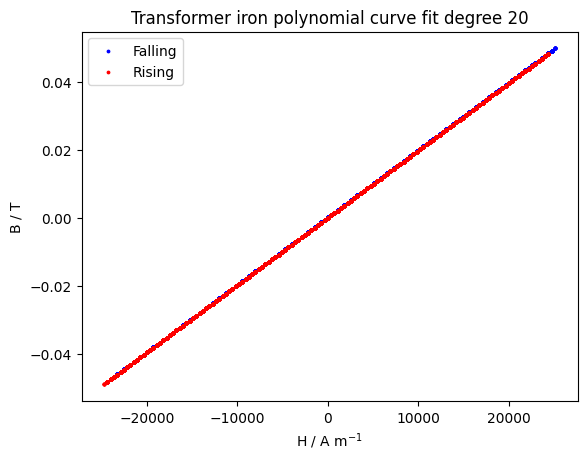

Area = 5.537730759713328 +- 6.148116193608697e-14


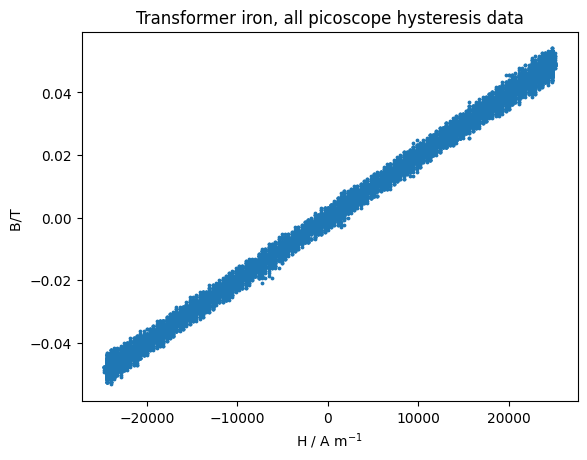

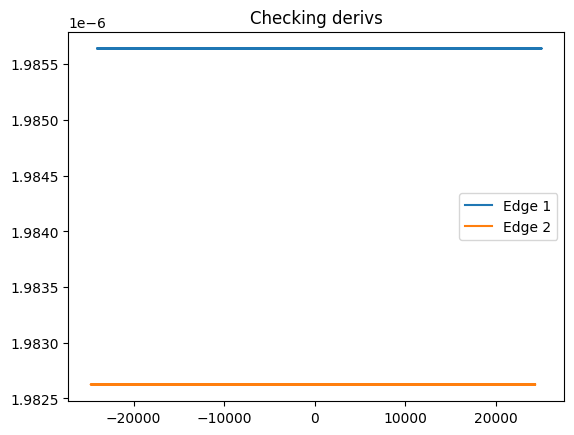

Min gradient edge 1: 1.985642225630002e-06
Max gradient edge 1: 1.985642225630002e-06
Min gradient edge 2: 1.9826250731484684e-06
Max gradient edge 2: 1.9826250731484684e-06
Max permeability: 1.5789233902762916 +- 0.0012004868287451905
Min permeability: 1.5789233902762916 +- 0.0012004868287451905


In [25]:

import matplotlib.pyplot as plt
import numpy as np

def moving_average(data, window_size):
  return np.convolve(data, np.ones(window_size)/ window_size, mode = "valid")



# modify this to allow different file inputs
file = open("CuNi_hightemp.csv","r")

count = 0
v_x_values = []
v_y_values = []

for line in file:
    count += 1
    if count > 3:  # first 3 lines of the file don't actually contain data
      line = line.strip() # removes trailing \n
      elements = line.split(",")
      time = float(elements[0])
      # swap these if channel setups are the other way around
      v_y = float(elements[1])  # v_y is channel A
      v_x = float(elements[2])  # v_x is channel B
      v_y_values.append(v_y)
      v_x_values.append(v_x)



file.close()


# Measured proportionality constants
n_p = 400
n_s = 500
# CHANGE ME - As is sample dependent
# For air: As = 3.12 * 10**-5
# For CuNi: As = 1.9635 * 10**-5
# For Mild Steel: As = 8.042477 * 10**-6
# For transformer iron: As = 2.125*10**-6
As = 1.9635 * 10**-5
Rp = 2.02
Ri = 9.916 * 10**3
C = 96.982 * 10**-9
Lp = 4.30 * 10**-2

# Converting from voltages to B and H by scaling with proportionality constants
# I'm going to keep H named as Vx and B named as Vy just to save changing lots of names

v_x_values = np.array(v_x_values) * n_p / (Lp * Rp)
v_y_values = np.array(v_y_values) * C * Ri / (n_s * As)


# Smoothing data with moving average, then finding turning points

window = 10000
x_smooth = moving_average(v_x_values, window)

dx_smooth = np.diff(x_smooth)  # dx_smooth[i] = x_smooth[i+1] - x_smooth[i]

sign_changes = np.diff(np.sign(dx_smooth))  # makes an array of 0 at most points but +2 for min (-ve to +ve) and -2 for max

turning_points = np.where(abs(sign_changes)==2) [0]

offset = (window - 1)//2
# this is because moving average[0] corresponds to x[window-1/2]
turning_points_original = turning_points + offset + 2
# extra +2 is because np.diff shifts by 1 each time you use it (??)


# The following is required as otherwise get several turning points chosen close together at extremes
min_separation = 50000

filtered_turning_points = []
for tp in turning_points_original:
    if len(filtered_turning_points) == 0:
        filtered_turning_points.append(tp)
    elif tp - filtered_turning_points[-1] > min_separation: # if neighbouring turning points are too close then reject
        filtered_turning_points.append(tp)

print(filtered_turning_points)
# this is a list of indices of where the turning points are


# first edge of loop
start = filtered_turning_points[0]
end = filtered_turning_points[1]
if v_y_values[start] > v_y_values[end]:
  tag1 = "Falling"
else:
  tag1 = "Rising"

print(start)
print(end)
edge1_x = v_x_values[start:end]
edge1_y = v_y_values[start:end]

"""
# For CuNi single loop plot add this line back in
#plt.plot(edge1_x, edge1_y)

# Extra exclusions for loops at the edges
# Used for CuNi low temperature as was hard to fit polynomial over entire range and didn't want extra loop area
# Keep this section commented out for all other samples
exclude_start = int(len(edge1_x) * 0.7)
exclude_stop = int(len(edge1_x) * 0.99)

edge1_x = edge1_x[exclude_start:exclude_stop]
edge1_y = edge1_y[exclude_start:exclude_stop]
# End of commented out section"""

# second edge
start = filtered_turning_points[1]
end = filtered_turning_points[2]
if v_y_values[start] > v_y_values[end]:
  tag2 = "Falling"
else:
  tag2 = "Rising"

print(start)
print(end)

edge2_x = v_x_values[start:end]
edge2_y = v_y_values[start:end]


"""
# Used for CuNi low temperature loop
#plt.plot(edge2_x, edge2_y)
#plt.title("CuNi low temperature, single loop of data")
#plt.savefig("CuNi_lowtemp_singleloop.png", dpi=300, bbox_inches="tight")
#plt.show()

# extra exclusions again

exclude_start = int(len(edge2_x) * 0.7)
exclude_stop = int(len(edge2_x) * 0.99)
edge2_x = edge2_x[exclude_start:exclude_stop]
edge2_y = edge2_y[exclude_start:exclude_stop]

# end of section to have commented out"""

# now curve fitting these lines
degree = int(input("What degree poly?")) # depends on sample, 10-15 good for mild steel, 20-30 for transformer iron
coefficients1 = np.polyfit(edge1_x, edge1_y, degree)
poly1 = np.poly1d(coefficients1)
coefficients2 = np.polyfit(edge2_x, edge2_y, degree)
poly2 = np.poly1d(coefficients2)
y1_fit = poly1(edge1_x)
y2_fit = poly2(edge2_x)

plt.scatter(edge1_x, y1_fit, s=3, c = "blue", label = tag1 )
plt.scatter(edge2_x, y2_fit, s=3, c = "red", label = tag2)
plt.legend()
plt.xlabel(r"H / A m$^{-1}$")
plt.ylabel("B / T")
# Change these lines depending on what the sample is and where you want to save it
plt.title("Transformer iron polynomial curve fit degree 20")
#plt.savefig("transformer_iron_curvefit.png", dpi = 300, bbox_inches = "tight")
plt.show()


# Calculating the area
from scipy import integrate

# x range just picking which index is higher (so this doesn't matter which is rising or falling)
x_min = max(min(edge1_x), min(edge2_x))
x_max = min(max(edge1_x), max(edge2_x))

def curve_difference(x):
  diff = poly2(x) - poly1(x)
  return abs(diff) # area should always be positive so this ensures rising and falling are correct way around

area, error = integrate.quad(curve_difference, x_min, x_max)
print(f"Area = {area} +- {error}")


# i think this error is an underestimate (it's tiny!)
# larger error associated with applying a curve fit that isn't true to the data, so trying it with varying degrees of polynomials

plt.scatter(v_x_values, v_y_values, s=3)
plt.ylabel("B/T ")
plt.xlabel(r"H / A m$^{-1}$")
# change these lines between samples
plt.title("Transformer iron, all picoscope hysteresis data")
#plt.savefig("transformer_iron_picoscope.png", dpi = 300, bbox_inches = "tight")
plt.show()

# Min and max gradient calcs
poly1_deriv = poly1.deriv()
poly2_deriv = poly2.deriv()

gradients_1 = poly1_deriv(edge1_x)
gradients_2 = poly2_deriv(edge2_x)

plt.plot(edge1_x, gradients_1, label = "Edge 1")
plt.plot(edge2_x, gradients_2, label = "Edge 2")
plt.legend()
# Printing this so can check whether it looks sensible before using the data
plt.title("Checking derivs")
plt.show()

def permeability(gradient1, gradient2):
  u_0 = 4 * np.pi * 10**-7
  av = (gradient1 + gradient2)/ (2 * u_0)
  error = (gradient1 - gradient2)/ (2 * u_0)
  return av, error

# only looking at middle section for max
# sometimes polynomial goes up/ down at extremes but this is due to curve fit not data itself
start1 = int((len(gradients_1)*0.05)//1)
stop1 = int((len(gradients_1)*0.95)//1)

start2 = int((len(gradients_2)*0.05)//1)
stop2 = int((len(gradients_2)*0.95)//1)


min_gradient_1 = np.min(abs(gradients_1))
max_gradient_1 = np.max(abs(gradients_1[start1:stop1]))
min_gradient_2 = np.min(abs(gradients_2))
max_gradient_2 = np.max(abs(gradients_2[start2:stop2]))
print(f"Min gradient edge 1: {min_gradient_1}")
print(f"Max gradient edge 1: {max_gradient_1}")
print(f"Min gradient edge 2: {min_gradient_2}")
print(f"Max gradient edge 2: {max_gradient_2}")
u_0 = 4 * np.pi * 10**-7
max_permeability, error_max = permeability(max_gradient_1, max_gradient_2)
min_permeability, error_min = permeability(min_gradient_1, min_gradient_2)

print(f"Max permeability: {max_permeability} +- {error_max}")
print(f"Min permeability: {min_permeability} +- {error_min}")

